# Import

In [3]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, explained_variance_score, mean_absolute_percentage_error

# Load calcium traces

In [ ]:
"""
This script includes:
    -Bar plots of neuron mean and variance activity around points of interest (start, stimulus onset, response, 
    punishment/reward)
    -Clustering / covariance matrices around points of interest (for each session & across sessions)
    
for AIRPUFF sessions

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

In [4]:
#### change chosen animal!!
chosen_animal = 233

if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')



In [ ]:
#### change session number here
session = "10"

In [ ]:
# load csv calcium traces
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape
# display the top of the table
#df.head()

# EXTRACT THE DATA YOU WILL NEED FOR THE ANALYSIS
# as you can see from the head, first row is useless, the first column is time, all the other columns are channels
# calcium data are sampled at 100 msec. 
# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]

#plt.plot(np.arange(len(time_array)-1), time_sampling, '.')
#plt.show()

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

# create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()

# Check traces data

In [ ]:
# check your data - plot some channels
units = [2,5,10]
fig, axs = plt.subplots(len(units),1, figsize=(10,18))

for u in range(len(units)):
    axs[u].plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
    axs[u].set_xlabel('time (sec)')
    axs[u].set_ylabel('Deltaf/f')
    #axs[u].set_ylim([-0.001,0.01])
    axs[u].set_ylim([-1,60])
    axs[u].grid()
    axs[u].legend()
    
fig.suptitle('Calcium Imaging Granule Cells', y=0.9, fontsize=14, fontweight='bold')
plt.show()

# Load behavioural data

In [ ]:

# LOAD BEHAVIOURAL DATA
if chosen_animal == 233:
    bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    trials_response = trial_info['trial_info'][0,0][2].ravel()
    trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    n_trials = len(trials_end_time) # number of trials

elif chosen_animal== 232:
    # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

    bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in MATLAB this is a struct with the fields:
    trials_start_time = trial_info['trial_start_new'][0].ravel()
    trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
    trials_response = trial_info['trial_response'][0].ravel()
    trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
    trials_is_reward = trial_info['trial_is_reward'][0].ravel()
    trials_end_time = trial_info['trial_end_new'][0].ravel()
    n_trials = len(trials_end_time)
    

# restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

new_start = trials_stimulus_on - 0.5
new_end = np.zeros(shape=(n_trials,))

new_end[0:-1] = trials_stimulus_on[1:]-0.5
new_end[-1] = trials_end_time[-1]

    
# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

In [ ]:
# trial length, response time, time before stimulus appears and intertrial time
fig, axs = plt.subplots(2,2,figsize=(15,12))
trials_length = new_end - new_start
response_time = trials_response - trials_stimulus_on
stim_time = trials_stimulus_on - new_start
intertrial_time = []
for i in range(1,n_trials):
    intertrial_time.append(new_start[i] - new_end[i-1])

# plot variables in subplots
axs[0, 0].plot(np.arange(n_trials), trials_length)
axs[0, 0].set_title('trial length')
axs[0, 1].plot(np.arange(n_trials), response_time)
axs[0, 1].set_title('response_time')
axs[1, 0].plot(np.arange(n_trials), stim_time)
axs[1, 0].set_title('time before stimulus appear')
axs[1, 1].plot(np.arange(n_trials-1), intertrial_time)
axs[1, 1].set_title('intertrial time')

# label axes
for ax in axs.flat:
    ax.set(xlabel='trial number', ylabel='time')
    ax.grid()
    
plt.show()

In [ ]:
# split traces data into trials
X = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

In [ ]:
# check total number of timepoints
tot_tp = 0
for i in range(n_trials):
    tot_tp += len(X[i])
    
tot_tp*0.1

In [ ]:
# check number of timepoints between end of last trial and start of first trial
new_end[-1]-new_start[0]

# Bar plots of neuron activity (mean + var)

In [ ]:
####### START OF TRIAL
start_timepoint = 0
n_after_start = 7
start_window = {}

selected_trials = ((trials_response - new_start)/sampling_rate > n_after_start)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        start_window[i] = X[i][start_timepoint:n_after_start]

# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([start_window[i] for i in start_window]).mean(axis=0) # across trials
mean_activity = np.mean(mean_activity, axis=0) # across timepoints

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([start_window[i] for i in start_window]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [ ]:
####### STIMULUS ONSET
n_before_stim = 2
n_after_stim = 5
stim_onset_window = {}

for i in range(n_trials):
    # timepoints for stimulus onset and end of trial
    stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
    stim_onset_window[i] = X[i][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim]

# only trials with time window of 7
stim_onset_window_corr = {}
for i in range(n_trials):
    if len(stim_onset_window[i])>6:
        stim_onset_window_corr[i] = stim_onset_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [ ]:
####### RESPONSE
n_before_resp = 5
n_after_resp = 2
resp_window = {}


for i in range(n_trials):
    # timepoints for response and end of trial
    resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
    resp_window[i] = X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]

# only trials with time window of 7
resp_window_corr = {}
for i in range(n_trials):
    if len(resp_window[i])>6:
        resp_window_corr[i] = resp_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [ ]:
len(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp])

In [ ]:
####### PUNISHMENT
n_before_pun = 2
n_after_pun = 5
airpuff = 2
punish_window = {}

j=0
for i in range(n_trials):
    # only punishment trials
    if trials_is_reward[i]==0:
        # timepoints for response and end of trial
        resp_airpuff_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate) + airpuff
        punish_window[j] = X[i][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
        j+=1

# only trials with time window of 7
punish_window_corr = {}
for i in range(len(punish_window)):
    if len(punish_window[i])>6:
        punish_window_corr[i] = punish_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [ ]:
####### REWARD
n_before_rew = 2
n_after_rew = 5
rew_window = {}

j=0
for i in range(n_trials):
    # only reward trials
    if trials_is_reward[i]==1:
        # timepoints for response and end of trial
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        rew_window[j] = X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
        j+=1

# only trials with time window of 7
rew_window_corr = {}
for i in range(len(rew_window)):
    if len(rew_window[i])>6:
        rew_window_corr[i] = rew_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
#plt.ylim(0,8000)
plt.legend()
plt.show()

# pairwise correlations for all trials

In [ ]:
# 700msec at start of trial (all trials)
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # covariance matrix
    cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
    # append covariance matrices to list of trials
    cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: start of trial
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('700msec after start of trial')
plt.show()

In [ ]:
# mean covariance between channels across trials
#cov = np.mean(np.array(cov_trials), axis=0)
#mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
flat_cov = cov[mask].reshape(np.sum(mask),)
first_low_mask = flat_cov<0.2
prop_middle_corr = np.sum(flat_cov[first_low_mask]>-0.2)/np.sum(mask)

In [ ]:
prop_middle_corr

In [ ]:
prop_upper_extreme = np.sum(flat_cov>0.75)/np.sum(mask)
prop_lower_extreme = np.sum(flat_cov<-0.72)/np.sum(mask)

In [ ]:
fig = plt.subplots(figsize =(10, 5))

plt.bar(np.arange(1), prop_lower_extreme, color ='b', width = 0.7,
        edgecolor ='grey', label ='corr < -0.75')

plt.bar(np.arange(1), prop_middle_corr, width=0.7, bottom=prop_lower_extreme, color='grey', edgecolor ='grey', label='-0.2 < corr < 0.2')

plt.bar(np.arange(1), prop_upper_extreme, color ='r', width = 0.7, bottom=prop_middle_corr+prop_lower_extreme,
        edgecolor ='grey', label ='corr > 0.75') 
# Adding Xticks
plt.xlabel('sessions', fontweight ='bold', fontsize = 15)
plt.ylabel('proportion units', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
plt.legend()
plt.title('Units correlation around moments of interest - animal 232')
plt.show()


In [ ]:
prop_upper_extreme

In [ ]:
prop_middle_corr

In [ ]:
# 200msec before / 500msec after stimulus (all trials)
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials):
    if selected_trials[i]==1:
        # timepoints for response and end of trial
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        # covariance matrix
        cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset')
plt.show()

In [ ]:
# 500msec before / 200msec after response (all trials)
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_stim+n_after_stim

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # timepoint for response
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        # covariance matrix
        cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response')
plt.show()

# pairwise correlations for reward trials

In [ ]:
# 700msec at start of trial (reward trials)
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # only reward trials
    if trials_is_reward[i]==1:
        # covariance matrix
        cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: start of reward trials
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec at start (reward trials)')
plt.show()

In [ ]:
# 200msec before / 500msec after stimulus (reward trials)
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

for i in range(n_trials):
    # only reward trials
    if trials_is_reward[i]==1:
        # timepoints for response and end of trial
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        # covariance matrix
        cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset (reward trials)')
plt.show()

In [ ]:
# 500msec before / 200msec after response (reward trials)
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_resp+n_after_resp

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response (reward trials)')
plt.show()

In [ ]:
# 200msec before / 500msec after reward (reward trials)
cov_trials = []
n_before_rew = 2 # 200msec before
n_after_rew = 5 # 500msec after
time_window = n_before_rew+n_after_rew

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoints for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: reward
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after reward')
plt.show()

# pairwise correlations for punishment trials

In [ ]:
# 700msec at start of trial (punishment trials)
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # only punishment trials
    if trials_is_reward[i]==0:
        # covariance matrix
        cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: start of reward trials
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('700msec at start (punishment trials)')
plt.show()

In [ ]:
# 200msec before / 500msec after stimulus (punishment trials)
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

for i in range(n_trials):
    # only punishment trials
    if trials_is_reward[i]==0:
        # timepoints for response and end of trial
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        # covariance matrix
        cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset (punishment trials)')
plt.show()

In [ ]:
# 500msec before / 200msec after response (punishment trials)
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_resp + n_after_resp

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)

# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response (punishment trials)')
plt.show()

In [ ]:
# 200msec before / 500msec after airpuff in punishment trials
cov_trials = []
n_before_pun = 2 # 200msec before
n_after_pun = 5 # 500msec after
time_window = n_before_pun + n_after_pun
airpuff = 2

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoints for response
            resp_airpuff_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate) + airpuff
            # covariance matrix
            cov_trial = np.cov(X[i][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
    
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

### plot correlation matrix of channels: punishment
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after punishment (airpuff)')
plt.show()

In [ ]:
# how to make sense of all this information
# gather all the info about mean and variance of activity, at all the points of interest. 
# compute min max and mean of correlations around points of interest 
# plot all of them together- compute correlation - predict correlations from mean and variance. 

In [ ]:
# mean_activity, var_activity, pd.dataframe(cov).corr

In [ ]:
# for each session
# we have computed average neurons activity and its variance
# correlation between all the neurons

# now we ask
# could we predict the correlation just by looking at the mean and variance of the activity?

# if we have to check that, we would use 
# start, stim on, resp, pun, rew
# across trials
# mean cell1, mean cell2, var cell 1, var cell 2  ---> to predict corr cell12
# one regression per couple of cells




# for every session
    # for every cell pair i j 
        # from the difference in mean activity and variance between two moment of interest 
        # predict the difference in correlation between two moments of inteerest 

            
            
            
            

In [ ]:
# code for this session compute response correlation

# 500msec before / 200msec after response (all trials)
cov_trials_start = []
cov_trials_resp=[]
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
start_timepoint = 0
n_after_start = 7
time_window = n_before_stim+n_after_stim

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

start_window = np.zeros(shape=(n_trials_,time_window,n_channels))
resp_window = np.zeros(shape=(n_trials_,time_window,n_channels))

j=0
for i in range(n_trials):
    if selected_trials[i]==1:
        # timepoint for response
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        start_window[j] = X[i][start_timepoint:n_after_start]
        resp_window[j] = X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        # covariance matrix
        cov_trial_start = np.cov(start_window[j], rowvar=False)
        cov_trial_resp = np.cov(resp_window[j], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials_start.append(cov_trial_start)
        cov_trials_resp.append(cov_trial_resp)
        j +=1

mean_activity_start = np.mean(start_window, axis=1) # across timepoints
var_activity_start = np.var(start_window, axis=1)

mean_activity_resp = np.mean(resp_window, axis=1)
var_activity_resp =  np.var(resp_window, axis=1)

    
# mean covariance between channels across trials
cov_resp = np.array(cov_trials_resp)
cov_start = np.array(cov_trials_start)



In [ ]:
# predict cov diff from diff of mean and var of units
mean_diff = mean_activity_resp - mean_activity_start
var_diff = var_activity_resp - var_activity_start
cov_diff = cov_resp - cov_start


n_splits=5
decode_cov_diff_accuracy = []


for i in range(1,n_channels):
    for j in range(0,i):
        acc_ij = np.zeros(shape=(n_splits,))
        x = np.array([mean_diff[:,i], mean_diff[:,j], var_diff[:,i], var_diff[:,j]]).transpose(1,0)
        y = cov_diff[:,i,j]
        
        
        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = KFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(x,y):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            acc_ij[s] = explained_variance_score(y_test,y_pred)
            s +=1     
            
        decode_cov_diff_accuracy.append(np.mean(acc_ij))
        

In [ ]:
np.mean(np.array(decode_cov_diff_accuracy))

In [ ]:
# TEST ALSO RESP AND PUNISHMENT - AND THEN ON ALL SESSIONS

In [ ]:
# code for this session compute response correlation

# 500msec before / 200msec after response (all trials)
cov_trials_pun = []
cov_trials_resp=[]
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
n_before_pun = 2 # 200msec before
n_after_pun = 5 # 500msec after

time_window = n_before_stim+n_after_stim

selected_trials = trials_is_reward == 0

n_trials_ = np.sum(selected_trials)

resp_window = np.zeros(shape=(n_trials_,time_window,n_channels))
pun_window = np.zeros(shape = (n_trials_,time_window, n_channels))

j=0
for i in range(n_trials):
    if selected_trials[i]==1:
        # timepoint for response
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        
        resp_window[j] = X[i][resp_timepoint - n_before_resp:resp_timepoint + n_after_resp]
        pun_window[j] = X[i][resp_timepoint - n_before_pun:resp_timepoint + n_after_pun]
      
        cov_trial_resp = np.cov(resp_window[j], rowvar=False)
        cov_trial_pun = np.cov(pun_window[j], rowvar = False)
        # append covariance matrices to list of trials
        cov_trials_pun.append(cov_trial_pun)
        cov_trials_resp.append(cov_trial_resp)
        j +=1

mean_activity_pun = np.mean(pun_window, axis=1) # across timepoints
var_activity_pun = np.var(pun_window, axis=1)

mean_activity_resp = np.mean(resp_window, axis=1)
var_activity_resp =  np.var(resp_window, axis=1)

# mean covariance between channels across trials
cov_resp = np.array(cov_trials_resp)
cov_pun = np.array(cov_trials_pun)


In [ ]:
int((trials_response[0] - new_start[0]) / sampling_rate)    

In [ ]:
# predict cov diff from diff of mean and var of units
mean_diff = mean_activity_resp - mean_activity_pun
var_diff = var_activity_resp - var_activity_pun
cov_diff = cov_resp - cov_pun


n_splits=5
decode_cov_diff_accuracy = []


for i in range(1,n_channels):
    for j in range(0,i):
        x = np.array([mean_diff[:,i], mean_diff[:,j], var_diff[:,i], var_diff[:,j]]).transpose(1,0)
        y = cov_diff[:,i,j]
        acc_ij = np.zeros(shape=(n_splits,))
             
        # cross validation to avoid overfitting
        outer_skf = KFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(x,y):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            acc_ij[s] = explained_variance_score(y_test,y_pred)
            s +=1     
            
        decode_cov_diff_accuracy.append(np.mean(acc_ij))
        

In [27]:
# do separately airpuff and non airpuff sessions 
chosen_animal=233


if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')


In [16]:
# do separately airpuff and non airpuff sessions 

# initiate empty lists
expl_var_resp_pun_diff = []

prop_middle_corr_pun = []
prop_upper_extreme_pun = []
prop_lower_extreme_pun = []


prop_middle_corr_resp = []
prop_upper_extreme_resp = []
prop_lower_extreme_resp = []




# for each airpuff session:
for session in non_airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    # compute difference between avg activity and correlations in response and punishment

    # 500msec before / 200msec after response (all trials)
    corr_trials_pun = []
    corr_trials_resp=[]
    n_before_resp = 5 # 500msec before
    n_after_resp = 2 # 200msec after
    n_before_pun = 2 # 200msec before
    n_after_pun = 5 # 500msec after

    time_window = n_before_resp+n_after_resp

    selected_trials = trials_is_reward[0:-1] == 0

    n_trials_ = np.sum(selected_trials)

    resp_window = np.zeros(shape=(n_trials_,time_window,n_channels))
    pun_window = np.zeros(shape = (n_trials_,time_window, n_channels))

    j=0
    for i in range(n_trials-1):
        if selected_trials[i]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        
            resp_window[j] = X[i][resp_timepoint - n_before_resp:resp_timepoint + n_after_resp]
            pun_window[j] = X[i][resp_timepoint - n_before_pun:resp_timepoint + n_after_pun]
      
            corr_trial_resp = np.corrcoef(resp_window[j], rowvar=False)
            corr_trial_pun = np.corrcoef(pun_window[j], rowvar = False)
            # append covariance matrices to list of trials
            corr_trials_pun.append(corr_trial_pun)
            corr_trials_resp.append(corr_trial_resp)
            j +=1

    mean_activity_pun = np.mean(pun_window, axis=1) # across timepoints
    var_activity_pun = np.var(pun_window, axis=1)

    mean_activity_resp = np.mean(resp_window, axis=1)
    var_activity_resp =  np.var(resp_window, axis=1)

    # mean covariance between channels across trials
    corr_resp = np.array(corr_trials_resp)
    corr_pun = np.array(corr_trials_pun)
    
    
    
    
    corr_resp = np.array(corr_trials_resp)
    corr_pun = np.array(corr_trials_pun)
    
    # proportion of corr 
    mean_corr_pun_session = np.mean(corr_pun, axis=0)
    mask_pun = np.triu(np.ones_like(mean_corr_pun_session, dtype=bool))
    flat_corr_pun = mean_corr_pun_session[mask_pun].reshape(np.sum(mask_pun),)
    first_low_mask = flat_corr_pun<=0.2
    prop_middle_corr_pun.append(np.sum(flat_corr_pun[first_low_mask]>=-0.2)/np.sum(mask_pun))
    prop_upper_extreme_pun.append(np.sum(flat_corr_pun>0.75)/np.sum(mask_pun))
    prop_lower_extreme_pun.append(np.sum(flat_corr_pun<-0.4)/np.sum(mask_pun))
    
    mean_corr_resp_session = np.mean(corr_resp, axis=0)
    mask_resp = np.triu(np.ones_like(mean_corr_resp_session, dtype=bool))
    flat_corr_resp = mean_corr_resp_session[mask_resp].reshape(np.sum(mask_resp),)
    first_low_mask = flat_corr_resp<=0.2
    prop_middle_corr_resp.append(np.sum(flat_corr_resp[first_low_mask]>=-0.2)/np.sum(mask_resp))
    prop_upper_extreme_resp.append(np.sum(flat_corr_resp>0.75)/np.sum(mask_resp))
    prop_lower_extreme_resp.append(np.sum(flat_corr_resp<-0.4)/np.sum(mask_resp))
    
    
    
    # predict cov diff from diff of mean and var of units
    mean_diff = mean_activity_resp - mean_activity_pun
    var_diff = var_activity_resp - var_activity_pun
    cov_diff = corr_resp - corr_pun


    n_splits=5
    decode_cov_diff_accuracy = []


    for i in range(1,n_channels):
        for j in range(0,i):
            x = np.array([mean_diff[:,i], mean_diff[:,j], var_diff[:,i], var_diff[:,j]]).transpose(1,0)
            y = cov_diff[:,i,j]
            acc_ij = np.zeros(shape=(n_splits,))
             
            # cross validation to avoid overfitting
            outer_skf = KFold(n_splits=n_splits)
            s=0
            for train_index, test_index in outer_skf.split(x,y):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #should be a grid search for tuning the parameter
                model = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
                model.fit(x_train, y_train)

                y_pred = model.predict(x_test)
                #acc_ij[s] = explained_variance_score(y_test,y_pred)
                acc_ij[s] = explained_variance_score(y_test,y_pred)
                s +=1     
            # every pair of units
            #decode_cov_diff_accuracy.append(np.mean(acc_ij))
            expl_var_resp_pun_diff.append(np.mean(acc_ij))
    # every session    
    #expl_var_resp_pun_diff.append([np.mean(np.array(decode_cov_diff_accuracy)), np.var(np.array(decode_cov_diff_accuracy))])
low_explained_variance_proportion = np.sum(np.array(expl_var_resp_pun_diff)<=0.1)/len(expl_var_resp_pun_diff)
high_explained_variance_proportion = np.sum(np.array(expl_var_resp_pun_diff)>=0.5)/len(expl_var_resp_pun_diff)

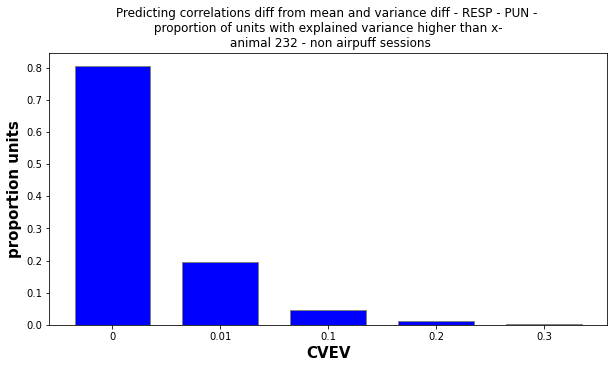

In [17]:
# bar plot showing the amount of data points with explained variance below a certain threshold
# x-axis = values of explained variance
# y-axis = amount of points with explained variance higher than the corresponding x value
expl_var_above_03 = np.sum(np.array(expl_var_resp_pun_diff)>=0.3)/len(expl_var_resp_pun_diff)
expl_var_above_02 = np.sum(np.array(expl_var_resp_pun_diff)>=0.2)/len(expl_var_resp_pun_diff)
expl_var_above_01 = np.sum(np.array(expl_var_resp_pun_diff)>=0.1)/len(expl_var_resp_pun_diff)
expl_var_above_001 = np.sum(np.array(expl_var_resp_pun_diff)>=0.01)/len(expl_var_resp_pun_diff)
expl_var_below_001 = np.sum(np.array(expl_var_resp_pun_diff)<0.01)/len(expl_var_resp_pun_diff)


fig = plt.subplots(figsize =(10, 5))

data = [expl_var_below_001,expl_var_above_001,expl_var_above_01,expl_var_above_02, expl_var_above_03]
plt.bar(np.arange(5), data, color ='b', width = 0.7,edgecolor ='grey')

plt.xticks(np.arange(5), ["0","0.01","0.1","0.2","0.3"])
#plt.xticks(np.arange(len(non_airpuff_sessions)*2+1), ['06','07','08','09','10','11','12','13', '', '06','07','08','09','10','11','12','13'])
plt.xlabel('CVEV', fontweight ='bold', fontsize = 15)
plt.ylabel('proportion units', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
str_title = 'Predicting correlations diff from mean and variance diff - RESP - PUN - \n proportion of units with explained variance higher than x- \n animal 232 - non airpuff sessions'
plt.title(str_title)
plt.show()

In [42]:
expl_var_resp_pun_diff

4676

In [72]:
low_prop_ev_233_a_resp_pun = low_explained_variance_proportion
high_prop_ev_233_a_resp_pun = high_explained_variance_proportion

In [69]:
low_prop_ev_233_na_resp_pun = low_explained_variance_proportion
high_prop_ev_233_na_resp_pun = high_explained_variance_proportion

In [46]:
low_prop_ev_232_a_resp_pun = low_explained_variance_proportion
high_prop_ev_232_a_resp_pun = high_explained_variance_proportion

In [56]:
low_prop_ev_232_na_resp_pun = low_explained_variance_proportion
high_prop_ev_232_na_resp_pun = high_explained_variance_proportion

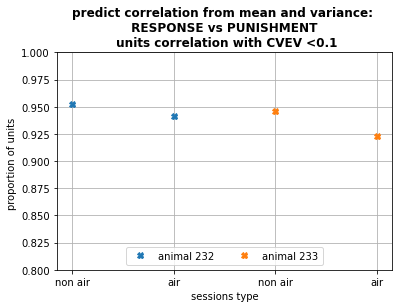

In [77]:
# plot 
fig = plt.figure()
plt.plot(np.arange(2), [low_prop_ev_232_na_resp_pun, low_prop_ev_232_a_resp_pun],'X', label='animal 232')
plt.plot(np.arange(2,4), [low_prop_ev_233_na_resp_pun, low_prop_ev_233_a_resp_pun], 'X', label='animal 233')
plt.ylim([.8,1])
plt.xticks([0,1,2,3], ['non air', 'air', 'non air', 'air'])
plt.grid()
plt.legend(loc='lower center', ncol=2)
plt.xlabel('sessions type')
plt.ylabel('proportion of units ')
title_str = "predict correlation from mean and variance: \n RESPONSE vs PUNISHMENT \n units correlation with CVEV <0.1"     
plt.title(title_str, fontweight='bold')
plt.show()


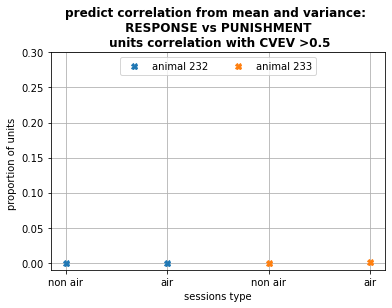

In [80]:
# plot 
fig = plt.figure()
plt.plot(np.arange(2), [high_prop_ev_232_na_resp_pun, high_prop_ev_232_a_resp_pun],'X', label='animal 232')
plt.plot(np.arange(2,4), [high_prop_ev_233_na_resp_pun, high_prop_ev_233_a_resp_pun], 'X', label='animal 233')
plt.ylim([-0.01,0.3])
plt.xticks([0,1,2,3], ['non air', 'air', 'non air', 'air'])
plt.grid()
plt.legend(loc='upper center', ncol=2)
plt.xlabel('sessions type')
plt.ylabel('proportion of units ')
title_str = "predict correlation from mean and variance: \n RESPONSE vs PUNISHMENT \n units correlation with CVEV >0.5"     
plt.title(title_str, fontweight='bold')
plt.show()

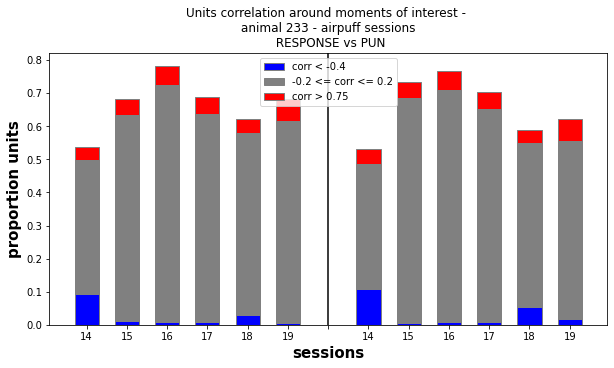

In [73]:
fig = plt.subplots(figsize =(10, 5))

for i in range(1,len(airpuff_sessions)+1):
    j=len(airpuff_sessions) +1 + i
    plt.bar(np.arange(i-1,i), prop_lower_extreme_resp[i-1], color ='b', width = 0.6,
        edgecolor ='grey', label ='corr < -0.4')

    plt.bar(np.arange(i-1,i), prop_middle_corr_resp[i-1], width=0.6, bottom=prop_lower_extreme_resp[i-1], color='grey', edgecolor ='grey', label='-0.2 <= corr <= 0.2')

    plt.bar(np.arange(i-1,i), prop_upper_extreme_resp[i-1], color ='r', width = 0.6, bottom=prop_lower_extreme_resp[i-1]+prop_middle_corr_resp[i-1],
        edgecolor ='grey', label ='corr > 0.75') 
    

    if i==1:
        plt.legend(loc="upper center")
        
    plt.bar(np.arange(j-1,j), prop_lower_extreme_pun[i-1], color ='b', width = 0.6,
        edgecolor ='grey', label ='corr < -0.5')

    plt.bar(np.arange(j-1,j), prop_middle_corr_pun[i-1], width=0.6, bottom=prop_lower_extreme_pun[i-1], color='grey', edgecolor ='grey', label='-0.5 <= corr <= 0.5')

    plt.bar(np.arange(j-1,j), prop_upper_extreme_pun[i-1], color ='r', width = 0.6, bottom=prop_middle_corr_pun[i-1]+prop_lower_extreme_pun[i-1],
        edgecolor ='grey', label ='corr > 0.5') 

plt.axvline(x=len(airpuff_sessions), color='k')
# Adding Xticks
plt.xticks(np.arange(len(airpuff_sessions)*2+1), ['14','15','16','17','18','19', '', '14','15','16','17','18','19'])
#plt.xticks(np.arange(len(non_airpuff_sessions)*2+1), ['06','07','08','09','10','11','12','13', '', '06','07','08','09','10','11','12','13'])
plt.xlabel('sessions', fontweight ='bold', fontsize = 15)
plt.ylabel('proportion units', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
str_title = 'Units correlation around moments of interest - \n animal 233 - airpuff sessions \n RESPONSE vs PUN'
plt.title(str_title)
plt.show()

In [25]:

# initiate empty lists
expl_var_resp_start_diff= []

prop_middle_corr_start = []
prop_upper_extreme_start = []
prop_lower_extreme_start = []


prop_middle_corr_resp = []
prop_upper_extreme_resp = []
prop_lower_extreme_resp = []

# for each airpuff session:
for session in airpuff_sessions:
    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    # compute difference between avg activity and correlations in response and punishment

    # 500msec before / 200msec after response (all trials)
    corr_trials_start = []
    corr_trials_resp=[]
    n_before_resp = 5 # 500msec before
    n_after_resp = 2 # 200msec after
    start_timepoint = 0
    n_after_start = 7 # 500msec after

    time_window = n_before_resp+n_after_resp


    selected_trials = ((trials_response[0:-1] - new_start[0:-1])/sampling_rate > time_window)

    n_trials_ = np.sum(selected_trials)

    resp_window = np.zeros(shape=(n_trials_,time_window,n_channels))
    start_window = np.zeros(shape=(n_trials_,time_window,n_channels))  

    j=0
    for i in range(n_trials-1):
        if selected_trials[i]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
            start_window[j] = X[i][start_timepoint:n_after_start]
            resp_window[j] = X[i][resp_timepoint - n_before_resp:resp_timepoint + n_after_resp]
            
            corr_trial_resp = np.corrcoef(resp_window[j], rowvar=False)
            corr_trial_start = np.corrcoef(start_window[j], rowvar = False)
            # append covariance matrices to list of trials
            corr_trials_start.append(corr_trial_start)
            corr_trials_resp.append(corr_trial_resp)
            j +=1

    mean_activity_start = np.mean(start_window, axis=1) # across timepoints
    var_activity_start = np.var(start_window, axis=1)

    mean_activity_resp = np.mean(resp_window, axis=1)
    var_activity_resp =  np.var(resp_window, axis=1)

    # mean covariance between channels across trials
    corr_resp = np.array(corr_trials_resp)
    corr_start = np.array(corr_trials_start)
    
    # proportion of corr 
    mean_corr_start_session = np.mean(corr_start, axis=0)
    mask_start = np.triu(np.ones_like(mean_corr_start_session, dtype=bool))
    flat_corr_start = mean_corr_start_session[mask_start].reshape(np.sum(mask_start),)
    first_low_mask = flat_corr_start<=0.2
    prop_middle_corr_start.append(np.sum(flat_corr_start[first_low_mask]>=-0.2)/np.sum(mask_start))
    prop_upper_extreme_start.append(np.sum(flat_corr_start>0.75)/np.sum(mask_start))
    prop_lower_extreme_start.append(np.sum(flat_corr_start<-0.4)/np.sum(mask_start))
    
    mean_corr_resp_session = np.mean(corr_resp, axis=0)
    mask_resp = np.triu(np.ones_like(mean_corr_resp_session, dtype=bool))
    flat_corr_resp = mean_corr_resp_session[mask_resp].reshape(np.sum(mask_resp),)
    first_low_mask = flat_corr_resp<=0.2
    prop_middle_corr_resp.append(np.sum(flat_corr_resp[first_low_mask]>=-0.2)/np.sum(mask_resp))
    prop_upper_extreme_resp.append(np.sum(flat_corr_resp>0.75)/np.sum(mask_resp))
    prop_lower_extreme_resp.append(np.sum(flat_corr_resp<-0.4)/np.sum(mask_resp))
    
    
    
    
    
    
    # predict cov diff from diff of mean and var of units
    mean_diff = mean_activity_resp - mean_activity_start
    var_diff = var_activity_resp - var_activity_start
    corr_diff = corr_resp - corr_start


    n_splits=5
    decode_cov_diff_accuracy = []


    for i in range(1,n_channels):
        for j in range(0,i):
            x = np.array([mean_diff[:,i], mean_diff[:,j], var_diff[:,i], var_diff[:,j]]).transpose(1,0)
            y = corr_diff[:,i,j]
            acc_ij = np.zeros(shape=(n_splits,))
             
            # cross validation to avoid overfitting
            outer_skf = KFold(n_splits=n_splits)
            s=0
            for train_index, test_index in outer_skf.split(x,y):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #should be a grid search for tuning the parameter
                model = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
                model.fit(x_train, y_train)

                y_pred = model.predict(x_test)
                #acc_ij[s] = explained_variance_score(y_test,y_pred)
                acc_ij[s] = explained_variance_score(y_test,y_pred)
                s +=1     
            # every pair of units
            #decode_cov_diff_accuracy.append(np.mean(acc_ij))
            # store each pair for each session
            expl_var_resp_start_diff.append(np.mean(acc_ij))
            
            
low_explained_variance_proportion = np.sum(np.array(expl_var_resp_start_diff)<=0.1)/len(expl_var_resp_start_diff)
high_explained_variance_proportion = np.sum(np.array(expl_var_resp_start_diff)>=0.5)/len(expl_var_resp_start_diff)

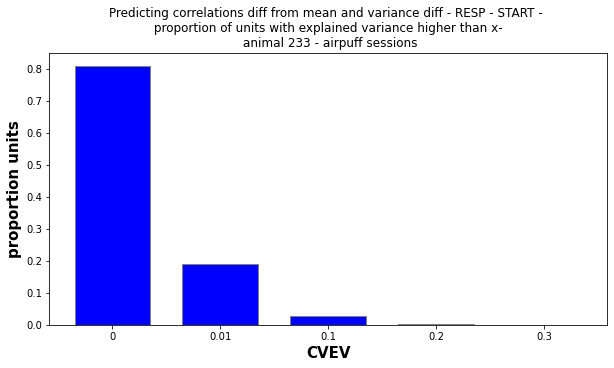

In [26]:
# bar plot showing the amount of data points with explained variance below a certain threshold
# x-axis = values of explained variance
# y-axis = amount of points with explained variance higher than the corresponding x value
expl_var_above_03 = np.sum(np.array(expl_var_resp_start_diff)>=0.3)/len(expl_var_resp_start_diff)
expl_var_above_02 = np.sum(np.array(expl_var_resp_start_diff)>=0.2)/len(expl_var_resp_start_diff)
expl_var_above_01 = np.sum(np.array(expl_var_resp_start_diff)>=0.1)/len(expl_var_resp_start_diff)
expl_var_above_001 = np.sum(np.array(expl_var_resp_start_diff)>=0.01)/len(expl_var_resp_start_diff)
expl_var_below_001 = np.sum(np.array(expl_var_resp_start_diff)<0.01)/len(expl_var_resp_start_diff)


fig = plt.subplots(figsize =(10, 5))

data = [expl_var_below_001,expl_var_above_001,expl_var_above_01,expl_var_above_02, expl_var_above_03]
plt.bar(np.arange(5), data, color ='b', width = 0.7,edgecolor ='grey')

plt.xticks(np.arange(5), ["0","0.01","0.1","0.2","0.3"])
#plt.xticks(np.arange(len(non_airpuff_sessions)*2+1), ['06','07','08','09','10','11','12','13', '', '06','07','08','09','10','11','12','13'])
plt.xlabel('CVEV', fontweight ='bold', fontsize = 15)
plt.ylabel('proportion units', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)
str_title = 'Predicting correlations diff from mean and variance diff - RESP - START - \n proportion of units with explained variance higher than x- \n animal 233 - airpuff sessions'
plt.title(str_title)
plt.show()

In [53]:
low_prop_ev_232_a_start_resp = low_explained_variance_proportion
high_prop_ev_232_a_start_resp = high_explained_variance_proportion

In [59]:
low_prop_ev_232_na_start_resp = low_explained_variance_proportion
high_prop_ev_232_na_start_resp = high_explained_variance_proportion

In [75]:
low_prop_ev_233_a_start_resp = low_explained_variance_proportion
high_prop_ev_233_a_start_resp = high_explained_variance_proportion

In [7]:
low_prop_ev_233_na_start_resp = low_explained_variance_proportion
high_prop_ev_233_na_start_resp = high_explained_variance_proportion

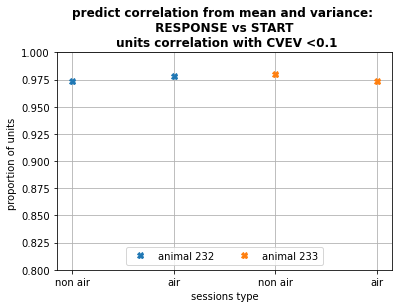

In [81]:
# plot 
fig = plt.figure()
plt.plot(np.arange(2), [low_prop_ev_232_na_start_resp, low_prop_ev_232_a_start_resp],'X', label='animal 232')
plt.plot(np.arange(2,4), [low_prop_ev_233_na_start_resp, low_prop_ev_233_a_start_resp], 'X', label='animal 233')
plt.ylim([.8,1])
plt.xticks([0,1,2,3], ['non air', 'air', 'non air', 'air'])
plt.grid()
plt.legend(loc='lower center', ncol=2)
plt.xlabel('sessions type')
plt.ylabel('proportion of units ')
title_str = "predict correlation from mean and variance: \n RESPONSE vs START \n units correlation with CVEV <0.1"     
plt.title(title_str, fontweight='bold')
plt.show()


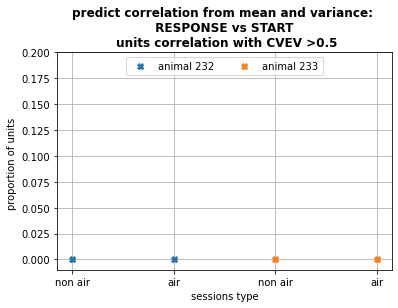

In [82]:
# plot 
fig = plt.figure()
plt.plot(np.arange(2), [high_prop_ev_232_na_start_resp, high_prop_ev_232_a_start_resp],'X', label='animal 232')
plt.plot(np.arange(2,4), [high_prop_ev_233_na_start_resp, high_prop_ev_233_a_start_resp], 'X', label='animal 233')
plt.ylim([-0.01,0.2])
plt.xticks([0,1,2,3], ['non air', 'air', 'non air', 'air'])
plt.grid()
plt.legend(loc='upper center', ncol=2)
plt.xlabel('sessions type')
plt.ylabel('proportion of units ')
title_str = "predict correlation from mean and variance: \n RESPONSE vs START \n units correlation with CVEV >0.5"     
plt.title(title_str, fontweight='bold')
plt.show()


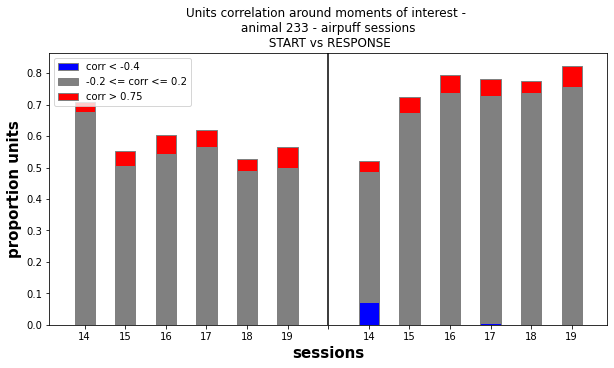

In [76]:
fig = plt.subplots(figsize =(10, 5))

for i in range(1,len(airpuff_sessions)+1):
    j=len(airpuff_sessions) +1 + i
    plt.bar(np.arange(i-1,i), prop_lower_extreme_start[i-1], color ='b', width = 0.5,
        edgecolor ='grey', label ='corr < -0.4')

    plt.bar(np.arange(i-1,i), prop_middle_corr_start[i-1], width=0.5, bottom=prop_lower_extreme_start[i-1], color='grey', edgecolor ='grey', label='-0.2 <= corr <= 0.2')

    plt.bar(np.arange(i-1,i), prop_upper_extreme_start[i-1], color ='r', width = 0.5, bottom=prop_lower_extreme_start[i-1]+prop_middle_corr_start[i-1],
        edgecolor ='grey', label ='corr > 0.75') 
    
    if i==1:
        plt.legend()
    
    plt.bar(np.arange(j-1,j), prop_lower_extreme_resp[i-1], color ='b', width = 0.5,
        edgecolor ='grey', label ='corr < -0.5')

    plt.bar(np.arange(j-1,j), prop_middle_corr_resp[i-1], width=0.5, bottom=prop_lower_extreme_resp[i-1], color='grey', edgecolor ='grey', label='-0.5 <= corr <= 0.5')

    plt.bar(np.arange(j-1,j), prop_upper_extreme_resp[i-1], color ='r', width = 0.5, bottom=prop_middle_corr_resp[i-1]+prop_lower_extreme_resp[i-1],
        edgecolor ='grey', label ='corr > 0.5') 

plt.axvline(x=len(airpuff_sessions), color='k')
# Adding Xticks
plt.xticks(np.arange(len(airpuff_sessions)*2+1), ['14','15','16','17','18','19', '', '14','15','16','17','18','19'])
#plt.xticks(np.arange(len(non_airpuff_sessions)*2+1), ['06','07','08','09','10','11','12','13', '', '04','06','07','08','10','11','12','13'])
plt.xlabel('sessions', fontweight ='bold', fontsize = 15)
plt.ylabel('proportion units', fontweight ='bold', fontsize = 15)
#plt.ylim(0,25)

str_title = 'Units correlation around moments of interest - \n animal 233 - airpuff sessions \n START vs RESPONSE'
plt.title(str_title)
plt.show()


In [98]:
# do separately airpuff and non airpuff sessions 
chosen_animal=233


if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')


In [74]:
# get average activity and standard deviation around points of interest, comparing with PCA violin plot


# labels for plotting
label1 = 'start'
label2 = 'stimulus onset'
label3 = 'response'
label4 = 'punishment'
label5 = 'reward'

# initiate empty lists
var_start = []
var_stim_onset = []
var_resp = []
var_punish = []
var_reward = []

mean_start = []
mean_stim_onset = []
mean_resp = []
mean_punish = []
mean_reward = []


# for each airpuff session:
for session in airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:] # this trial, timepoints, all units, 
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # all units, all trials, non airpuff sessions, average activity around start of the trial
    # for this specific session take the averaage across trials and units
    mean_start_session = []
    var_start_session = []
    # start of trial
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_start_pertrial = np.mean(x, axis=1) # for every trial, mean activity of all units across timepoints
            
            mean_start_session.append(np.mean(mean_activity_start_pertrial)) # mean across units
            var_start_session.append(np.var(mean_activity_start_pertrial)) # variance across units
            
    # for this session, average mean activity across trials        
    mean_start.append(np.mean(mean_start_session))
    var_start.append(np.mean(np.array(var_start_session)))
    
    
    # stimulus onset
    mean_stim_onset_session = []
    var_stim_onset_session = []

    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_stimonset_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_stim_onset_session.append(np.mean(mean_activity_stimonset_pertrial)) # across units
            var_stim_onset_session.append(np.var(mean_activity_stimonset_pertrial)) # variance across units
            
    # for this session        
    mean_stim_onset.append(np.mean(mean_stim_onset_session))
    var_stim_onset.append(np.mean(np.array(var_stim_onset_session)))
    
    
    # response
    mean_resp_session = []
    var_resp_session = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_resp_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_resp_session.append(np.mean(mean_activity_resp_pertrial)) # across units
            var_resp_session.append(np.var(mean_activity_resp_pertrial)) # variance across units
            
            
    # for this session        
    mean_resp.append(np.mean(mean_resp_session))
    var_resp.append(np.mean(np.array(var_resp_session)))
            
            
    # punishment
    mean_punish_session = []
    var_punish_session = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            mean_activity_punish_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_punish_session.append(np.mean(mean_activity_punish_pertrial)) # across units
            var_punish_session.append(np.var(mean_activity_punish_pertrial)) # variance across units
            
            
    # for this session        
    mean_punish.append(np.mean(mean_punish_session))
    var_punish.append(np.mean(np.array(var_punish_session)))
    
    # reward
    mean_reward_session = []
    var_reward_session = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            mean_activity_reward_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_reward_session.append(np.mean(mean_activity_reward_pertrial)) # across units
            var_reward_session.append(np.var(mean_activity_reward_pertrial)) # variance across units
            
            
    # for this session        
    mean_reward.append(np.mean(mean_reward_session))
    var_reward.append(np.mean(np.array(var_reward_session)))
    
    

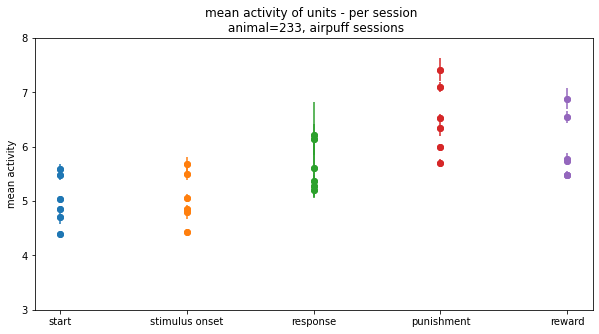

In [75]:
data = np.array([mean_start, mean_stim_onset, mean_resp, mean_punish, mean_reward])
err = np.array([var_start, var_stim_onset, var_resp, var_punish, var_reward])

fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('mean activity of units - per session \n animal=233, airpuff sessions')
for i in range(5):
    x = np.ones(shape=(len(airpuff_sessions),))*i
    ax.scatter(x,data[i])
  
    ax.errorbar(x, data[i], yerr=err[i], fmt="o")


#ax.boxplot(data)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
ax.set_ylim(3,8)
ax.set_ylabel('mean activity')
plt.show()
    

# Units mean and variance of activity per trial 

In [101]:
# get average activity and standard deviation around points of interest, comparing with PCA violin plot


# labels for plotting
label1 = 'start'
label2 = 'stimulus onset'
label3 = 'response'
label4 = 'punishment'
label5 = 'reward'

# initiate empty lists
var_start = []
var_stim_onset = []
var_resp = []
var_punish = []
var_reward = []

mean_start = []
mean_stim_onset = []
mean_resp = []
mean_punish = []
mean_reward = []


# for each airpuff session:
for session in non_airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:] # this trial, timepoints, all units, 
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # all units, all trials, non airpuff sessions, average activity around start of the trial
    # for this specific session take the averaage across trials and units
    mean_start_session = []
    var_start_session = []
    # start of trial
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_start_pertrial = np.mean(x, axis=1) # for every trial, mean activity of all units across timepoints
            
            mean_start.append(np.mean(mean_activity_start_pertrial)) # mean across units
            var_start.append(np.var(mean_activity_start_pertrial)) # variance across units
            
 
    
    
    # stimulus onset
    mean_stim_onset_session = []
    var_stim_onset_session = []

    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_stimonset_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_stim_onset.append(np.mean(mean_activity_stimonset_pertrial)) # across units
            var_stim_onset.append(np.var(mean_activity_stimonset_pertrial)) # variance across units
            
    
    # response
    mean_resp_session = []
    var_resp_session = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>5: # make sure that time window is not too small
            mean_activity_resp_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_resp.append(np.mean(mean_activity_resp_pertrial)) # across units
            var_resp.append(np.var(mean_activity_resp_pertrial)) # variance across units
            
            
    # punishment
    mean_punish_session = []
    var_punish_session = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            mean_activity_punish_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_punish.append(np.mean(mean_activity_punish_pertrial)) # across units
            var_punish.append(np.var(mean_activity_punish_pertrial)) # variance across units
            
            
    # reward
    mean_reward_session = []
    var_reward_session = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            mean_activity_reward_pertrial = np.mean(x, axis=1) # across timepoints
            
            mean_reward.append(np.mean(mean_activity_reward_pertrial)) # across units
            var_reward.append(np.var(mean_activity_reward_pertrial)) # variance across units
            

<ipython-input-102-c7322733775f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([mean_start, mean_stim_onset, mean_resp, mean_punish, mean_reward])
<ipython-input-102-c7322733775f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  err = np.array([var_start, var_stim_onset, var_resp, var_punish, var_reward])


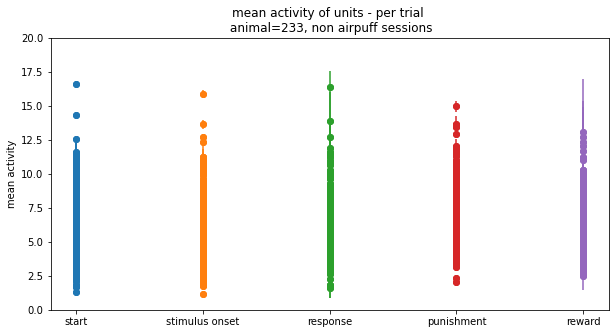

In [102]:
data = np.array([mean_start, mean_stim_onset, mean_resp, mean_punish, mean_reward])
err = np.array([var_start, var_stim_onset, var_resp, var_punish, var_reward])

fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('mean activity of units - per trial \n animal=233, non airpuff sessions')
for i in range(5):
    x = np.ones(shape=(len(data[i]),))*i
    ax.scatter(x,data[i])
  
    ax.errorbar(x, data[i], yerr=err[i], fmt="o")


#ax.boxplot(data)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
ax.set_ylim(0,20)
ax.set_ylabel('mean activity')
plt.show()
    

In [78]:
data.shape

(5,)

In [80]:
len(data[0])

623